# **Multimodal Early Fusion for Lung Cancer Subtype Classification (LUAD vs LUSC)**

We implemet the **early fusion strategy** using the four heterogenous data modalities:
- Clinical data
- RNA-seq gene expression
- DNA methylation
- Whole Slide Image (WSI) deep features

Features from all modalities are **concatenated at the feature level** into a single high-dimensional representation before model training.

$$\mathbf{x}_{fusion} = [\mathbf{x}_{RNA}, \mathbf{x}_{Methylation}, \mathbf{x}_{WSI}, \mathbf{x}_{Clinical}]$$

A **single classifer** is then trained on the fused representation enabling the model to learn cross-modal interactions, leverage complementary biological information and perform joint pattern discovery across omics, images and clinical data


**Workflow**
1. Loading preprocessed features from all four modalities
2. Harmonizing patients across datasets using 'patient_id' column
3. Constructing the early-fusion feature matrix
4. Train/test splitting with stratification
5. Feature scaling
6. Training classification models
7. Evaluating performance

This early fusion model will later be **compared against unimodal models and late fusion strategies** to assess the benefit of multimodal integration.


### Load the data

In [1]:
import os 

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, RocCurveDisplay

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

In [2]:
DATA_DIR = r"C:\Users\glori\Desktop\Lung-Cancer\Data"

LABELS_PATH = os.path.join(DATA_DIR, "multiomics_labels.tsv")

labels = pd.read_csv(LABELS_PATH, sep="\t")

print("Labels shape:", labels.shape)
labels.head()

Labels shape: (831, 3)


,patient_id,subtype,subtype_simple
0,TCGA-MP-A4SV,TCGA-LUAD,LUAD
1,TCGA-55-8621,TCGA-LUAD,LUAD
2,TCGA-MN-A4N1,TCGA-LUAD,LUAD
3,TCGA-55-6986,TCGA-LUAD,LUAD
4,TCGA-86-6851,TCGA-LUAD,LUAD


In [3]:
# ==== Load modality-specific source tables ====

# Paths to each modality (based on your folder screenshot)
CLINICAL_PATH   = os.path.join(DATA_DIR, "clinical_cleaned.csv")
RNA_PATH        = os.path.join(DATA_DIR, "multiomics_rna_logCPM_TMM.tsv")
METH_PATH       = os.path.join(DATA_DIR, "multiomics_meth_beta_values.tsv")
WSI_FEAT_PATH   = os.path.join(DATA_DIR, "multiomics_wsi_features_resnet50.tsv")

# Load data
clinical_raw = pd.read_csv(CLINICAL_PATH)
rna_raw      = pd.read_csv(RNA_PATH,  sep="\t")
meth_raw     = pd.read_csv(METH_PATH, sep="\t")
wsi_raw      = pd.read_csv(WSI_FEAT_PATH, sep="\t")

print("Clinical raw shape:", clinical_raw.shape)
print("RNA raw shape:     ", rna_raw.shape)
print("Meth raw shape:    ", meth_raw.shape)
print("WSI features shape:", wsi_raw.shape)

display(clinical_raw.head())
display(rna_raw.iloc[:5, :5])   # show first few columns
display(meth_raw.iloc[:5, :5])
display(wsi_raw.iloc[:5, :5])


Clinical raw shape: (1089, 99)
RNA raw shape:      (831, 17811)
Meth raw shape:     (831, 10001)
WSI features shape: (828, 2049)


,project,submitter_id,morphology,days_to_diagnosis,created_datetime,tissue_or_organ_of_origin,age_at_diagnosis,primary_diagnosis,classification_of_tumor,tumor_of_origin,...,treatments_radiation_treatment_intent_type,treatments_radiation_treatment_dose_units,treatments_radiation_course_number,treatments_radiation_prescribed_dose_units,treatments_radiation_route_of_administration,treatments_radiation_number_of_cycles,treatments_radiation_prescribed_dose,treatments_radiation_initial_disease_status,bcr_patient_barcode,patient_id
0,TCGA-LUAD,TCGA-MP-A4SV,8140/3,0.0,NaN,"Lower lobe, lung",24516.0,"Adenocarcinoma, NOS",primary,NaN,...,Adjuvant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-MP-A4SV,TCGA-MP-A4SV
1,TCGA-LUAD,TCGA-55-8621,8140/3,0.0,NaN,"Lower lobe, lung",27485.0,"Adenocarcinoma, NOS",primary,NaN,...,Adjuvant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-55-8621,TCGA-55-8621
2,TCGA-LUAD,TCGA-MN-A4N1,8140/3,0.0,NaN,"Upper lobe, lung",21939.0,"Adenocarcinoma, NOS",primary,NaN,...,Adjuvant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-MN-A4N1,TCGA-MN-A4N1
3,TCGA-LUAD,TCGA-55-6986,8252/3,0.0,NaN,"Lower lobe, lung",NaN,"Bronchiolo-alveolar carcinoma, non-mucinous",primary,NaN,...,Adjuvant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-55-6986,TCGA-55-6986
4,TCGA-LUAD,TCGA-86-6851,8255/3,0.0,NaN,"Upper lobe, lung",26808.0,Adenocarcinoma with mixed subtypes,primary,NaN,...,Adjuvant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-86-6851,TCGA-86-6851


,patient_id,ENSG00000000003.15,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17
0,TCGA-MP-A4SV,5.394902,4.952867,4.235412,3.557212
1,TCGA-55-8621,5.106508,4.469044,3.573832,2.163817
2,TCGA-MN-A4N1,6.038168,4.933833,3.890689,3.051575
3,TCGA-55-6986,6.838805,5.025933,3.778696,1.857313
4,TCGA-86-6851,5.145167,4.726781,4.293288,3.245869


,patient_id,cg26841862,cg23057992,cg23091104,cg16602369
0,TCGA-MP-A4SV,NaN,0.946858,0.977531,0.065308
1,TCGA-55-8621,NaN,0.959341,0.972107,0.928264
2,TCGA-MN-A4N1,NaN,0.936614,0.972540,0.089290
3,TCGA-55-6986,NaN,0.965030,0.983624,0.915223
4,TCGA-86-6851,NaN,0.953744,0.978243,0.067880


,patient_id,wsi_feat_0,wsi_feat_1,wsi_feat_2,wsi_feat_3
0,TCGA-05-4384,-0.685059,-0.327518,2.100388,1.287895
1,TCGA-05-4390,-0.829199,-0.552474,0.777593,0.821114
2,TCGA-05-4396,-0.657156,-0.100464,-0.732600,-0.971890
3,TCGA-05-4405,0.993652,-0.839902,-0.632169,1.229618
4,TCGA-05-4410,-0.639592,-0.857846,-0.143215,1.358694


Clean labels and create numeric outcome y

In [4]:
print("Original label columns: ", labels.columns.tolist())
print("First few raw label rows:")
display(labels.head())

Original label columns:  ['patient_id', 'subtype', 'subtype_simple']
First few raw label rows:


,patient_id,subtype,subtype_simple
0,TCGA-MP-A4SV,TCGA-LUAD,LUAD
1,TCGA-55-8621,TCGA-LUAD,LUAD
2,TCGA-MN-A4N1,TCGA-LUAD,LUAD
3,TCGA-55-6986,TCGA-LUAD,LUAD
4,TCGA-86-6851,TCGA-LUAD,LUAD


In [5]:
if labels.shape[1] == 1:
    col = labels.columns[0]
    split_df = labels[col].str.split("\t", expand=True)
    # Expecting 3 fields: patient_id, subtype, subtype_simple
    split_df.columns = ["patient_id", "subtype", "subtype_simple"]
    labels = split_df

# Keep only patient_id and the simplified subtype
labels = labels[["patient_id", "subtype_simple"]].copy()

In [6]:
labels["patient_id"] = labels["patient_id"].str.strip()
labels["subtype_simple"] = labels["subtype_simple"].str.strip()

# Drop any rows without a valid subtype
labels = labels.dropna(subset=["subtype_simple"]).reset_index(drop=True)

In [7]:
# Encode LUAD / LUSC as 0/1
le = LabelEncoder()
labels["y"] = le.fit_transform(labels["subtype_simple"])

print("Encoded classes (label -> numeric):")
class_mapping = {cls: int(code) for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(class_mapping)

print("Labels after cleaning:", labels.shape)
labels.head()

Encoded classes (label -> numeric):
{'LUAD': 0, 'LUSC': 1}
Labels after cleaning: (831, 3)


,patient_id,subtype_simple,y
0,TCGA-MP-A4SV,LUAD,0
1,TCGA-55-8621,LUAD,0
2,TCGA-MN-A4N1,LUAD,0
3,TCGA-55-6986,LUAD,0
4,TCGA-86-6851,LUAD,0


#### Harmonize patient IDs across all modaliteis

1. Make sure every table has a 'patient_id' column

In [8]:
# In the clinical table the ID is usually called 'submitter_id'
if "patient_id" not in clinical_raw.columns and "submitter_id" in clinical_raw.columns:
    clinical_raw = clinical_raw.rename(columns={"submitter_id": "patient_id"})

In [9]:
# Convert all IDs to string and strip whitespace (safety)
for df in [clinical_raw, rna_raw, meth_raw, wsi_raw, labels]:
    df["patient_id"] = df["patient_id"].astype(str).str.strip()

2. Compute intersection of patients present in all 4 modalities and labels

In [10]:
patients_clin = set(clinical_raw["patient_id"])
patients_rna = set(rna_raw["patient_id"])
patients_meth = set(meth_raw["patient_id"])
patients_wsi = set(wsi_raw["patient_id"])
patients_lab = set(labels["patient_id"])

common_patients = (patients_clin & patients_rna & patients_meth & patients_wsi & patients_lab)

print("Common patients: ", len(common_patients))

Common patients:  828


3. Restrict each table to the common patient set and sort by patient_id

In [11]:
def align_to_common(df, name):
    df2 = df[df["patient_id"].isin(common_patients)].copy()
    df2 = df2.sort_values("patient_id").reset_index(drop=True)
    print(f"{name} aligned shape: {df2.shape}")
    return df2

clinical_aligned = align_to_common(clinical_raw, "Clinical")
rna_aligned = align_to_common(rna_raw, "RNA")
meth_aligned = align_to_common(meth_raw, "Methylation")
wsi_aligned = align_to_common(wsi_raw, "WSI")
labels_aligned = align_to_common(labels, "Labels")

Clinical aligned shape: (828, 99)
RNA aligned shape: (828, 17811)
Methylation aligned shape: (828, 10001)
WSI aligned shape: (828, 2049)
Labels aligned shape: (828, 3)


In [12]:
print("Head of patient_id alignment check:")
print("Clinical:", clinical_aligned["patient_id"].head().tolist())
print("RNA:     ", rna_aligned["patient_id"].head().tolist())
print("Meth:    ", meth_aligned["patient_id"].head().tolist())
print("WSI:     ", wsi_aligned["patient_id"].head().tolist())
print("Labels:  ", labels_aligned["patient_id"].head().tolist())

Head of patient_id alignment check:
Clinical: ['TCGA-05-4384', 'TCGA-05-4390', 'TCGA-05-4396', 'TCGA-05-4405', 'TCGA-05-4410']
RNA:      ['TCGA-05-4384', 'TCGA-05-4390', 'TCGA-05-4396', 'TCGA-05-4405', 'TCGA-05-4410']
Meth:     ['TCGA-05-4384', 'TCGA-05-4390', 'TCGA-05-4396', 'TCGA-05-4405', 'TCGA-05-4410']
WSI:      ['TCGA-05-4384', 'TCGA-05-4390', 'TCGA-05-4396', 'TCGA-05-4405', 'TCGA-05-4410']
Labels:   ['TCGA-05-4384', 'TCGA-05-4390', 'TCGA-05-4396', 'TCGA-05-4405', 'TCGA-05-4410']


## Build per-modlaity feature matrices and the target vector

In [13]:
# We'll keep a copy of the patient IDs for reference
patient_ids = clinical_aligned["patient_id"].copy()

1. Clinical features
- use only numeric columns
- Exclude the ID column

In [14]:
clinical_num_cols = clinical_aligned.select_dtypes(include=[np.number]).columns.tolist()
if "y" in clinical_num_cols:
    clinical_num_cols("y")
clinical_features = clinical_aligned[clinical_num_cols].copy()

print("Clinical feature matrix: ", clinical_features.shape)

Clinical feature matrix:  (828, 39)


2. RNA features
- All coumns exept patient_id are exept patient_id are expression values

In [15]:
rna_features = rna_aligned.drop(columns=["patient_id"]).copy()
print("RNA feature matrix:", rna_features.shape)

RNA feature matrix: (828, 17810)


3. Methylation features
- All columns except patient_id are CpG beta values

In [16]:
meth_features = meth_aligned.drop(columns=["patient_id"]).copy()
print("Methylation feature matrix:", meth_features.shape)

Methylation feature matrix: (828, 10000)


In [17]:
wsi_features = wsi_aligned.drop(columns=["patient_id"]).copy()
print("WSI feature matrix:", wsi_features.shape)

WSI feature matrix: (828, 2048)


5. Target vector

In [18]:
y = labels_aligned["y"].to_numpy()
print("Target vector y shape: ", y.shape)
print("Class balance:", np.bincount(y), " (order:", dict(enumerate(np.unique(labels_aligned['subtype_simple']))), ")")

Target vector y shape:  (828,)
Class balance: [456 372]  (order: {0: 'LUAD', 1: 'LUSC'} )


## Standardize each modality separately

This ensures that no modality dominates the learning process simply due to magnitude

In [19]:
import numpy as np

def report_nans(name, df):
    n_total = df.size
    n_nan = np.isnan(df.values).sum()
    print(f"{name}: NaNs = {n_nan} / {n_total}")

report_nans("Clinical", clinical_features)
report_nans("RNA",      rna_features)
report_nans("Meth",     meth_features)
report_nans("WSI",      wsi_features)


Clinical: NaNs = 25640 / 32292
RNA: NaNs = 0 / 14746680
Meth: NaNs = 656760 / 8280000
WSI: NaNs = 0 / 1695744


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- Impute missing values ---

# Clinical: use median (robust to outliers, sensible for mixed-scale clinical vars)
imp_clin = SimpleImputer(strategy="median")
X_clin_imp = imp_clin.fit_transform(clinical_features)

# Omics & WSI: they’re already continuous and roughly on a similar scale; 
# we’ll use mean imputation (most NaNs should be rare, if any).
imp_omics = SimpleImputer(strategy="mean")

X_rna_imp  = imp_omics.fit_transform(rna_features)
X_meth_imp = imp_omics.fit_transform(meth_features)
X_wsi_imp  = imp_omics.fit_transform(wsi_features)

# Quick sanity check after imputation
print("NaNs after imputation:")
print("  Clinical:", np.isnan(X_clin_imp).sum())
print("  RNA:     ", np.isnan(X_rna_imp).sum())
print("  Meth:    ", np.isnan(X_meth_imp).sum())
print("  WSI:     ", np.isnan(X_wsi_imp).sum())

# --- Standardize each modality separately (zero mean, unit variance) ---

scaler_clin = StandardScaler()
scaler_rna  = StandardScaler()
scaler_meth = StandardScaler()
scaler_wsi  = StandardScaler()

X_clin_scaled = scaler_clin.fit_transform(X_clin_imp)
X_rna_scaled  = scaler_rna.fit_transform(X_rna_imp)
X_meth_scaled = scaler_meth.fit_transform(X_meth_imp)
X_wsi_scaled  = scaler_wsi.fit_transform(X_wsi_imp)

print("Clinical scaled:",     X_clin_scaled.shape)
print("RNA scaled:",          X_rna_scaled.shape)
print("Methylation scaled:",  X_meth_scaled.shape)
print("WSI scaled:",          X_wsi_scaled.shape)

print("\nClinical mean/std (first 5 features):")
print(X_clin_scaled.mean(axis=0)[:5],
      X_clin_scaled.std(axis=0)[:5])


c:\Users\glori\.conda\envs\prompEng310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['created_datetime' 'tumor_of_origin' 'last_known_disease_status'
 'days_to_last_known_disease_status' 'days_to_recurrence' 'tumor_grade'
 'progression_or_recurrence' 'NA.' 'figo_stage'
 'figo_staging_edition_year' 'alcohol_intensity' 'cigarettes_per_day'
 'alcohol_history' 'year_of_birth' 'year_of_death'
 'treatments_pharmaceutical_treatment_dose'
 'treatments_pharmaceutical_number_of_fractions'
 'treatments_pharmaceutical_treatment_anatomic_sites'
 'treatments_pharmaceutical_course_number'
 'treatments_radiation_clinical_trial_indicator'
 'treatments_radiation_therapeutic_agents'
 'treatments_radiation_prescribed_dose_units'
 'treatments_radiation_route_of_administration'
 'treatments_radiation_number_of_cycles'
 'treatments_radiation_prescribed_dose']. At least one non-missing value is needed for imputation with strategy='median'.
  warnin

NaNs after imputation:
  Clinical: 0
  RNA:      0
  Meth:     0
  WSI:      0
Clinical scaled: (828, 14)
RNA scaled: (828, 17810)
Methylation scaled: (828, 10000)
WSI scaled: (828, 2048)

Clinical mean/std (first 5 features):
[ 0.00000000e+00  2.31698718e-16  1.51891382e-14 -1.72701359e-16
 -1.69054250e-15] [0. 1. 1. 1. 1.]


Imputation and modality-wise standardization.

First, I explicitly impute missing values before scaling. For clinical variables I use median imputation, which is robust to outliers and appropriate for heterogeneous clinical features. For the high-dimensional omics (RNA, DNA methylation) and WSI feature vectors I use mean imputation, since missing entries should be rare and the features are continuous.

After imputation, I apply a separate StandardScaler to each modality so that every feature has approximately zero mean and unit variance. This prevents any single modality (e.g. 17k RNA genes) from dominating purely due to scale when I later concatenate them for early fusion. The final printout confirms that there are no remaining NaNs and that the first few clinical features are properly standardized (mean ≈ 0, std ≈ 1).

### Build the early fusion-matrix

In [21]:
# Stack all fou modalities side-by-side
X_early = np.hstack([X_clin_scaled, X_rna_scaled, X_meth_scaled, X_wsi_scaled]).astype(np.float32)

print("Early-fusion matrix shape:", X_early.shape)

Early-fusion matrix shape: (828, 29872)


In [22]:
# Combined feature names
early_feature_names = (
    list(clinical_features.columns) +
    list(rna_features.columns) +
    list(meth_features.columns) +
    list(wsi_features.columns)
)
print("Number of feature names:", len(early_feature_names))

Number of feature names: 29897


We construct the matrix by horizontally concatenating (np.stack) the scaled feature matrices from the four modalities. All matrices have the same number of patients (rows) but different feature dimensions (columns), so hstack is appropriate (not stack, which would require identical shapes). Each row of X_early now represents one patient with all modalities combined as a single feature vector.

### Train/test with stratification

In [23]:
from sklearn.model_selection import train_test_split
import numpy as np

# y is already the integer-encoded label vector of length 828
print("y shape:", y.shape, "unique labels:", np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(
    X_early,
    y,
    test_size=0.2,          # 80/20 split
    random_state=42,
    stratify=y              # preserve LUAD/LUSC balance
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))

y shape: (828,) unique labels: [0 1]
Train shape: (662, 29872)  Test shape: (166, 29872)
Train class counts: [365 297]
Test  class counts: [91 75]


We split the early-fusion matrix and target vector into training and test sets using an 80/20 ratio. Stratification on the target vector ensures that LUAD/LUSC class balance is preserved in both splits.

# Models

## Logistic Regression

Logistic regression is a linear probabilistic classification model that estimates the probability of class membership using a logistic (sigmoid) function applied to a weighted linear combination of input features. It serves as a baseline early-fusion classifier, operating on the concatenated multimodal feature space. The model is trained with class balancing and L2 regularization to handle class imbalance and prevent overfitting in the high-dimensional setting

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import numpy as np

In [25]:
log_reg = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    solver="saga",
    n_jobs=1,
    verbose=1
)

log_reg.fit(X_train, y_train)

convergence after 2075 epochs took 205 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,5000
,multi_class,'deprecated'



=== Logistic Regression (Early Fusion) ===
Accuracy:   0.958
ROC–AUC:    0.998
Confusion matrix (rows=true, cols=pred):
 [[89  2]
 [ 5 70]]

Classification report:
               precision    recall  f1-score   support

        LUAD       0.95      0.98      0.96        91
        LUSC       0.97      0.93      0.95        75

    accuracy                           0.96       166
   macro avg       0.96      0.96      0.96       166
weighted avg       0.96      0.96      0.96       166



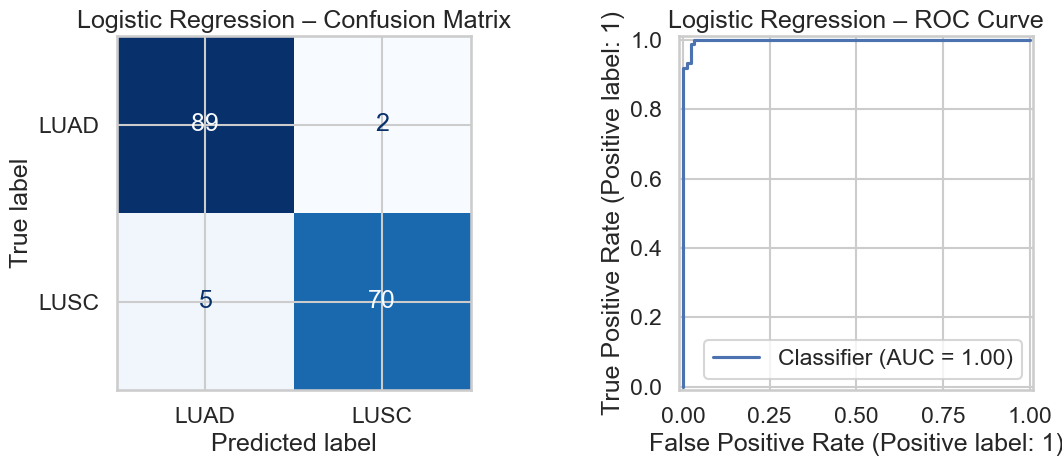

In [29]:
y_pred  = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm  = confusion_matrix(y_test, y_pred)

print(f"\n=== Logistic Regression (Early Fusion) ===")
print(f"Accuracy:   {acc:.3f}")
print(f"ROC–AUC:    {auc:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm)
print("\nClassification report:\n",
      classification_report(y_test, y_pred, target_names=["LUAD", "LUSC"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm, display_labels=["LUAD", "LUSC"]).plot(
    ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("Logistic Regression – Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("Logistic Regression – ROC Curve")

plt.tight_layout()
plt.show()

## SVM

In [30]:
from sklearn.svm import SVC

1. Define the SVM model

In [31]:
svm_clf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    class_weight="balanced",
    probability=True,
    random_state=42
)

2. Train on the features

In [32]:
svm_clf.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


3. Predictions

In [33]:
y_pred_svm = svm_clf.predict(X_test)
y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]


=== SVM (RBF Kernel, Early Fusion) ===
Accuracy:   0.964
ROC–AUC:    0.996
Confusion matrix (rows=true, cols=pred):
 [[90  1]
 [ 5 70]]

Classification report:
               precision    recall  f1-score   support

        LUAD       0.95      0.98      0.96        91
        LUSC       0.97      0.93      0.95        75

    accuracy                           0.96       166
   macro avg       0.96      0.96      0.96       166
weighted avg       0.96      0.96      0.96       166



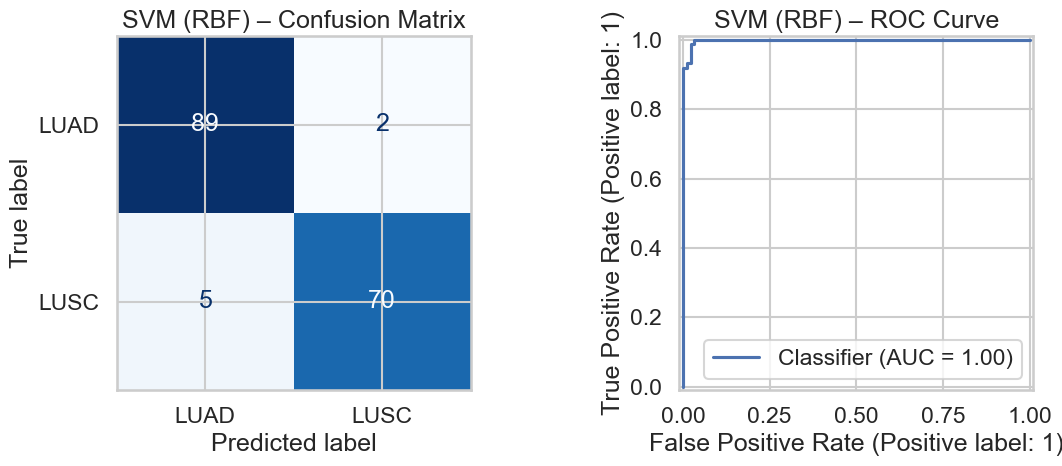

In [34]:
acc_svm = accuracy_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_proba_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print(f"\n=== SVM (RBF Kernel, Early Fusion) ===")
print(f"Accuracy:   {acc_svm:.3f}")
print(f"ROC–AUC:    {auc_svm:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm_svm)
print("\nClassification report:\n",
      classification_report(y_test, y_pred, target_names=["LUAD", "LUSC"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm, display_labels=["LUAD", "LUSC"]).plot(
    ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("SVM (RBF) – Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("SVM (RBF) – ROC Curve")

plt.tight_layout()
plt.show()

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rf_clf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [37]:
rf_clf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



=== Random Forest (Early Fusion) ===
Accuracy:   0.946
ROC–AUC:    0.993
Confusion matrix (rows=true, cols=pred):
 [[88  3]
 [ 6 69]]

Classification report:
               precision    recall  f1-score   support

        LUAD       0.94      0.97      0.95        91
        LUSC       0.96      0.92      0.94        75

    accuracy                           0.95       166
   macro avg       0.95      0.94      0.95       166
weighted avg       0.95      0.95      0.95       166



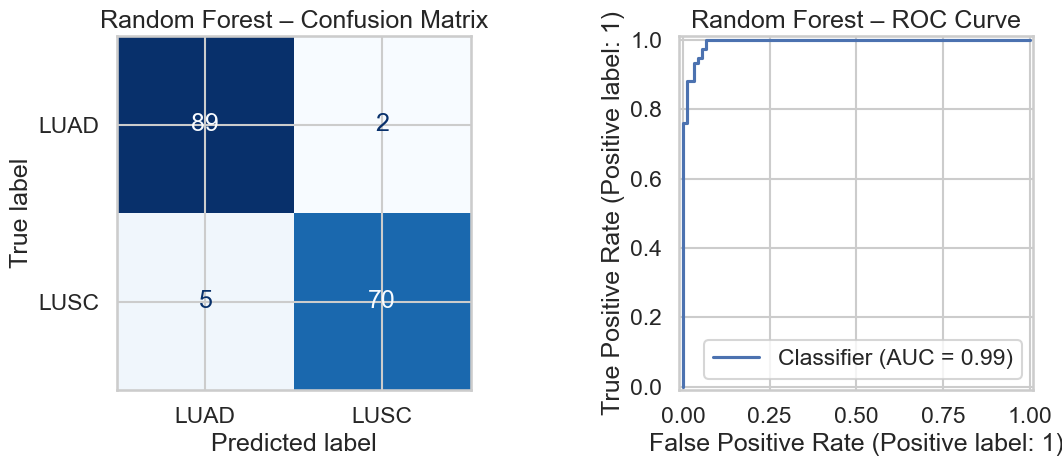

In [38]:
y_pred  = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred)
auc_rf = roc_auc_score(y_test, y_proba)
cm_rf  = confusion_matrix(y_test, y_pred)

print(f"\n=== Random Forest (Early Fusion) ===")
print(f"Accuracy:   {acc_rf:.3f}")
print(f"ROC–AUC:    {auc_rf:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm_rf)
print("\nClassification report:\n",
      classification_report(y_test, y_pred, target_names=["LUAD", "LUSC"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm, display_labels=["LUAD", "LUSC"]).plot(
    ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("Random Forest – Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("Random Forest – ROC Curve")

plt.tight_layout()
plt.show()

Total number of features in early fusion: 29872

=== Random Forest Feature Importance by Modality ===
Clinical    :   0.01% of total importance
RNA         :  33.12% of total importance
Methylation :  65.61% of total importance
WSI         :   1.26% of total importance


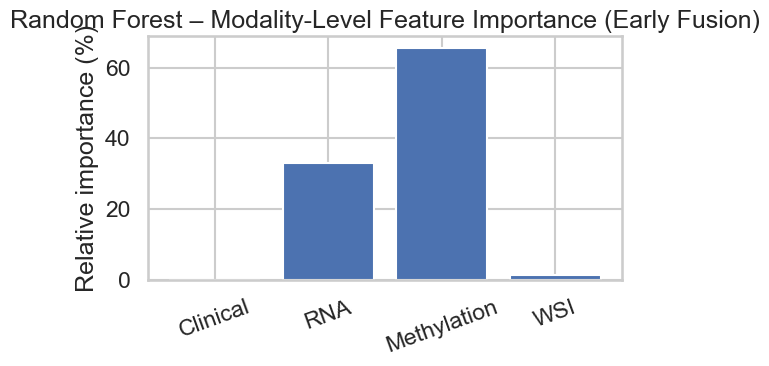

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Get per-feature importance from the trained RF model
rf_importances = rf_clf.feature_importances_     # shape: (n_features,)
print("Total number of features in early fusion:", rf_importances.shape[0])

# --- 2. Work out column ranges for each modality in X_early ---
n_clin = X_clin_scaled.shape[1]
n_rna  = X_rna_scaled.shape[1]
n_meth = X_meth_scaled.shape[1]
n_wsi  = X_wsi_scaled.shape[1]

idx_clin_start = 0
idx_clin_end   = idx_clin_start + n_clin

idx_rna_start  = idx_clin_end
idx_rna_end    = idx_rna_start + n_rna

idx_meth_start = idx_rna_end
idx_meth_end   = idx_meth_start + n_meth

idx_wsi_start  = idx_meth_end
idx_wsi_end    = idx_wsi_start + n_wsi

assert idx_wsi_end == rf_importances.shape[0], "Index ranges do not match X_early shape!"

# --- 3. Sum importances within each modality block ---
modality_importance = {
    "Clinical":    rf_importances[idx_clin_start:idx_clin_end].sum(),
    "RNA":         rf_importances[idx_rna_start:idx_rna_end].sum(),
    "Methylation": rf_importances[idx_meth_start:idx_meth_end].sum(),
    "WSI":         rf_importances[idx_wsi_start:idx_wsi_end].sum(),
}

# Normalize to percentages (just for nicer interpretation)
total_imp = sum(modality_importance.values())
modality_importance_pct = {k: 100 * v / total_imp for k, v in modality_importance.items()}

print("\n=== Random Forest Feature Importance by Modality ===")
for modality, val in modality_importance_pct.items():
    print(f"{modality:12s}: {val:6.2f}% of total importance")

# --- 4. Bar plot of modality importance ---
plt.figure(figsize=(6, 4))
plt.bar(modality_importance_pct.keys(), modality_importance_pct.values())
plt.ylabel("Relative importance (%)")
plt.title("Random Forest – Modality-Level Feature Importance (Early Fusion)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### Gradient Boosting

In [40]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb_model = HistGradientBoostingClassifier(
    max_iter=300,
    learning_rate=0.05,
    max_depth=8,
    class_weight="balanced",
    early_stopping=True,
    random_state=42
)

gb_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.05
,max_iter,300
,max_leaf_nodes,31
,max_depth,8
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


In [41]:
y_pred  = gb_model.predict(X_test)
y_proba = gb_model.predict_proba(X_test)[:, 1]


=== Gradient Boosting (Early Fusion) ===
Accuracy:   0.958
ROC–AUC:    0.993
Confusion matrix (rows=true, cols=pred):
 [[88  3]
 [ 4 71]]

Classification report:
               precision    recall  f1-score   support

        LUAD       0.96      0.97      0.96        91
        LUSC       0.96      0.95      0.95        75

    accuracy                           0.96       166
   macro avg       0.96      0.96      0.96       166
weighted avg       0.96      0.96      0.96       166



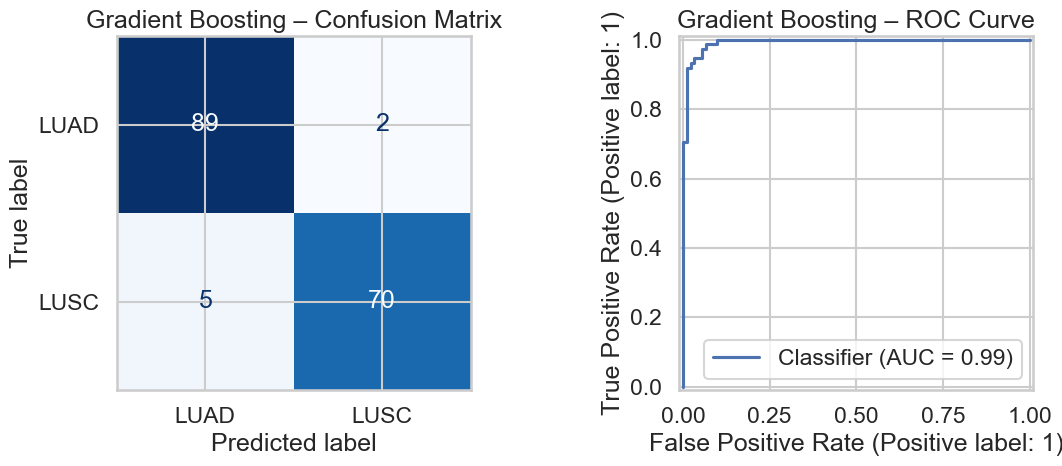

In [42]:
acc_gb = accuracy_score(y_test, y_pred)
auc_gb = roc_auc_score(y_test, y_proba)
cm_gb  = confusion_matrix(y_test, y_pred)

print(f"\n=== Gradient Boosting (Early Fusion) ===")
print(f"Accuracy:   {acc_gb:.3f}")
print(f"ROC–AUC:    {auc_gb:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm_gb)
print("\nClassification report:\n",
      classification_report(y_test, y_pred, target_names=["LUAD", "LUSC"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm, display_labels=["LUAD", "LUSC"]).plot(
    ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("Gradient Boosting – Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("Gradient Boosting – ROC Curve")

plt.tight_layout()
plt.show()


## Multilayer Perceptron (Deep Early Fusion model)

We implement a **Multilayer Perceptron (MLP)** nueral network. The goal is to determine whether a **deep nonlinear model** can better capture complex interactions among **clinical, RNA-seq, DNA methylation, and WSI-derived features** compared to classical machine learning models.

A Multilayer Perceptron is a **fully connected feed-forward neural network** composed of:
- An input layer which recieves the concatenated feature vector
- One or more hidden layers with nonlinear activation functions
- An output laer which produces class probabilities for LUAD vs LUSC

Unlike linear regression which learns a single linear decision boundary, an MLP can learn **hierarchical nonlinear representations** enabling it to model:
- Gene-methylation regulatory interactions
- Omics-image cross-modal nonlinear patterns
- High-order feature dependencies

**Network Architecture**

- input dimension: total number of features
- Hidden layer 1: 256 neurons with ReLU acivation
- Hidden layer 2: 128 neurons
- Output layer: 1 neuron with sigmoid activation 

**Training Strategy**

- Optimizer: Adam (Adaptive stochastic gradient descent)
- Loss function: Binary cross-entropy
- Class Imbalance Handling: Sample-weighted training using balanced class weights
- Regularization: L2 penalty to reduce overfitting
- Early stopping: Enabled using an internal validation split to prevent overfitting
- Batch Training: Mini-batch updates to stabilize convergence

### Define and Train MLP

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight

Balance classes via sample weights

In [44]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

In [45]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=64,
    learning_rate="adaptive",
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

mlp_model.fit(X_train, y_train, sample_weight=sample_weights)

,hidden_layer_sizes,"(256, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,64
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,42


Predictions

In [46]:
y_pred  = mlp_model.predict(X_test)
y_proba = mlp_model.predict_proba(X_test)[:, 1]

Evaluation


=== MLP Neural Network (Early Fusion) ===
Accuracy:   0.952
ROC–AUC:    0.984
Confusion matrix (rows=true, cols=pred):
 [[87  4]
 [ 4 71]]

Classification report:
               precision    recall  f1-score   support

        LUAD       0.96      0.96      0.96        91
        LUSC       0.95      0.95      0.95        75

    accuracy                           0.95       166
   macro avg       0.95      0.95      0.95       166
weighted avg       0.95      0.95      0.95       166



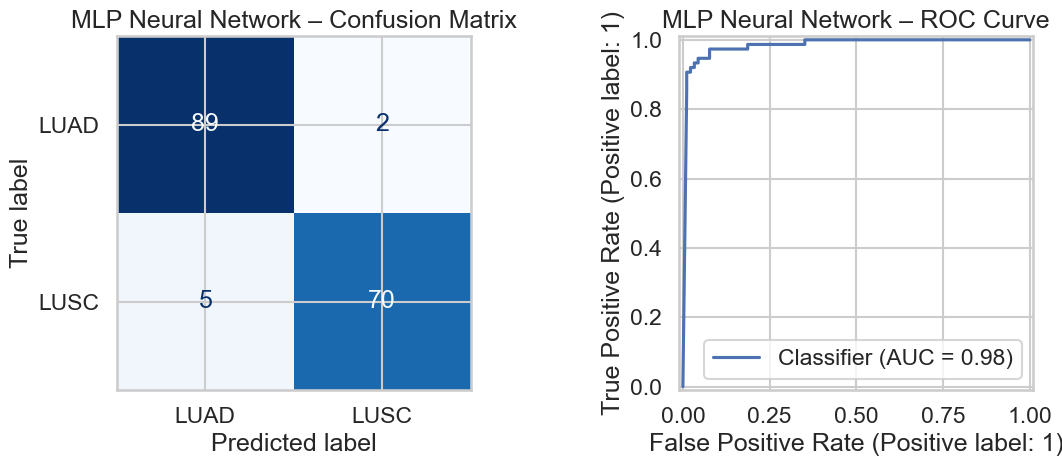

In [47]:
acc_mlp = accuracy_score(y_test, y_pred)
auc_mlp = roc_auc_score(y_test, y_proba)
cm_mlp  = confusion_matrix(y_test, y_pred)

print(f"\n=== MLP Neural Network (Early Fusion) ===")
print(f"Accuracy:   {acc_mlp:.3f}")
print(f"ROC–AUC:    {auc_mlp:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm_mlp)
print("\nClassification report:\n",
      classification_report(y_test, y_pred, target_names=["LUAD", "LUSC"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm, display_labels=["LUAD", "LUSC"]).plot(
    ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("MLP Neural Network – Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("MLP Neural Network – ROC Curve")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Collect results in a list of dicts
results = [
    {"Model": "Logistic Regression", "Accuracy": acc,      "AUC": auc},
    {"Model": "SVM (RBF kernel)",    "Accuracy": acc_svm,  "AUC": auc_svm},
    {"Model": "Random Forest",       "Accuracy": acc_rf,   "AUC": auc_rf},
    {"Model": "HistGradBoost",       "Accuracy": acc_gb,   "AUC": auc_gb},
    {"Model": "MLP",                 "Accuracy": acc_mlp,  "AUC": auc_mlp},
]

results_df = pd.DataFrame(results)

# Sort descending by AUC (change to "Accuracy" if you prefer)
results_df = results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)

print(results_df)

                 Model  Accuracy       AUC
0  Logistic Regression  0.957831  0.998242
1     SVM (RBF kernel)  0.963855  0.996044
2        HistGradBoost  0.957831  0.993260
3        Random Forest  0.945783  0.993114
4                  MLP  0.951807  0.984176


Logistic Regression achieved the highest AUC, demonstrating the strongest overall discriminative capacity between LUAD and LUSC across all classification thresholds. However, the SVM achieved the highest accuracy while maintaining a near-optimal AUC. As a result, the SVM was selected as the most effective early-fusion model for practical classification, while Logistic Regression served as the strongest linear benchmark.